In [1]:
basepath = 'C:/Users/shaur/Desktop/UTD/ANLP'

In [2]:
import sys
from pathlib import Path

In [3]:
base_folder = Path(basepath)
data_folder = base_folder/'datasets/emotion'
model_folder = base_folder/'models/nlp_spring_2024/emotion/nn'
custom_functions = base_folder/'custom_files'

In [4]:
sys.path.append(str(custom_functions))
model_folder.mkdir(exist_ok=True, parents = True)

In [5]:
import torch
import torch.nn as nn

# For working with textual data vocabularies and for displaying model summaries
from torchtext.vocab import vocab

# General-purpose Python libraries for random number generation and numerical operations
import random
import numpy as np

# Utilities for efficient serialization/deserialization of Python objects and for element tallying
import joblib
from collections import Counter
import re

# For creating lightweight attribute classes and for partial function application
from functools import partial

# For filesystem path handling, generating and displaying confusion matrices, and date-time manipulations
from sklearn.metrics import multilabel_confusion_matrix, hamming_loss, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from datetime import datetime
import pandas as pd
import emoji
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# For plotting and visualization
import matplotlib.pyplot as plt
import seaborn as sns

from kaggle import api

### NEW ##########################
# imports from Huggingface ecosystem
import evaluate
from datasets import load_dataset, DatasetDict, Dataset
from transformers import TrainingArguments, Trainer
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import AutoConfig
from transformers import pipeline
import wandb

c:\Users\shaur\anaconda3\envs\anlp\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
train = pd.read_csv(data_folder/'train.csv')
test = pd.read_csv(data_folder/'test.csv')

In [7]:
train.drop(columns=['ID'], inplace=True)
train.head()

,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,“Worry is a down payment on a problem you may ...,0,1,0,0,0,0,1,0,0,0,1
1,Whatever you decide to do make sure it makes y...,0,0,0,0,1,1,1,0,0,0,0
2,@Max_Kellerman it also helps that the majorit...,1,0,1,0,1,0,1,0,0,0,0
3,Accept the challenges so that you can literall...,0,0,0,0,1,0,1,0,0,0,0
4,My roommate: it's okay that we can't spell bec...,1,0,1,0,0,0,0,0,0,0,0


## Preprocessing

In [8]:
def get_emoji_regexp():
    emojis = sorted(emoji.EMOJI_DATA, key=len, reverse=True)
    pattern = u'(' + u'|'.join(re.escape(u) for u in emojis) + u')'
    return re.compile(pattern)

def strip_emoji(text):
    return re.sub(get_emoji_regexp(), r"", text)

def strip_all_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower()
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

#Filter special characters such as & and $ present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

def remove_mult_spaces(text): # remove multiple spaces
    return re.sub("\s\s+" , " ", text)

def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word.lower() not in stop_words]
    return ' '.join(filtered_text)

## With emojis

In [24]:
train_clean = train['Tweet'].apply(strip_all_entities).apply(clean_hashtags).apply(filter_chars).apply(remove_mult_spaces)
train['Tweet'] = train_clean

In [25]:
X = train['Tweet'].values
y = train.loc[:, train.columns != 'Tweet'].values
y = np.array(y, dtype=float)

In [26]:
X_train, X_val, y_train, y_val  = train_test_split(X, y, random_state=42,test_size=0.1)

In [27]:
trainset = Dataset.from_dict({
    'texts': X_train,
    'labels': y_train
})
validset = Dataset.from_dict({
    'texts': X_val,
    'labels': y_val
})

In [28]:
id2label = {0: "anger", 1: "anticipation", 2: "disgust", 3: "fear", 4: "joy", 5: "love", 6: "optimism", 7: "pessimism", 8: "sadness", 9: "surprise", 10: "trust"}
label2id = {id2label[k]: k for k in id2label}

In [29]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = nn.functional.sigmoid(torch.Tensor(logits))
    predictions = (predictions >= 0.5).int().numpy()

    overall_accuracy = accuracy_score(labels, predictions)
    overall_f1 = f1_score(labels, predictions, average='macro', zero_division=0)

    return {
        'eval_accuracy': overall_accuracy,
        'eval_f1': overall_f1
    }

In [15]:
checkpoint = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [29]:
def tokenize_fn(batch):
    return tokenizer(text = batch["texts"], truncation=True)

In [30]:
trainset_tokenized = trainset.map(tokenize_fn, batched=True)
validset_tokenized = validset.map(tokenize_fn, batched=True)
trainset_tokenized = trainset_tokenized.remove_columns(['texts'])
validset_tokenized = validset_tokenized.remove_columns(['texts'])
trainset_tokenized.set_format(type='torch')
validset_tokenized.set_format(type='torch')

Map: 100%|██████████| 773/773 [00:00<00:00, 38262.78 examples/s]


In [31]:
model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint, 
    problem_type="multi_label_classification", 
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
training_args = TrainingArguments(
    num_train_epochs=2,

    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    # weight_decay=0.01,  
    # learning_rate=2e-5, 
    optim='adamw_torch',

    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder/'bert'), 
    evaluation_strategy='steps', 
    eval_steps=100, 
    save_strategy="steps", 
    save_steps=100, 
    load_best_model_at_end=True, 
    save_total_limit=2, 
    metric_for_best_model="loss",
    greater_is_better=False, 
)

In [33]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=trainset_tokenized,
    eval_dataset=validset_tokenized,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

trainer.train()

c:\Users\shaur\anaconda3\envs\anlp\lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: shauryat1298 (shauryat12). Use `wandb login --relogin` to force relogin


                                                
 11%|█▏        | 100/870 [00:12<01:15, 10.16it/s]

{'eval_accuracy': 0.15135834411384216, 'eval_f1': 0.2467690879336191, 'eval_loss': 0.4064771234989166, 'eval_runtime': 1.2659, 'eval_samples_per_second': 610.656, 'eval_steps_per_second': 38.709, 'epoch': 0.23}


                                                 
 23%|██▎       | 200/870 [00:26<01:09,  9.61it/s]

{'eval_accuracy': 0.2095730918499353, 'eval_f1': 0.37230357779471634, 'eval_loss': 0.35265040397644043, 'eval_runtime': 1.3157, 'eval_samples_per_second': 587.515, 'eval_steps_per_second': 37.242, 'epoch': 0.46}


                                                 
 34%|███▍      | 300/870 [00:39<00:59,  9.64it/s]

{'eval_accuracy': 0.24838292367399742, 'eval_f1': 0.4336377169548166, 'eval_loss': 0.34121763706207275, 'eval_runtime': 1.3119, 'eval_samples_per_second': 589.244, 'eval_steps_per_second': 37.352, 'epoch': 0.69}


                                                 
 46%|████▌     | 400/870 [00:52<00:48,  9.67it/s]

{'eval_accuracy': 0.2445019404915912, 'eval_f1': 0.4287524609505278, 'eval_loss': 0.3226662278175354, 'eval_runtime': 1.3168, 'eval_samples_per_second': 587.031, 'eval_steps_per_second': 37.212, 'epoch': 0.92}


 57%|█████▋    | 500/870 [01:05<00:39,  9.37it/s]

{'loss': 0.363, 'grad_norm': 2.586293935775757, 'learning_rate': 2.1264367816091954e-05, 'epoch': 1.15}


                                                 
 57%|█████▋    | 500/870 [01:07<00:39,  9.37it/s]

{'eval_accuracy': 0.24838292367399742, 'eval_f1': 0.48399863942223625, 'eval_loss': 0.3225821852684021, 'eval_runtime': 1.3489, 'eval_samples_per_second': 573.043, 'eval_steps_per_second': 36.325, 'epoch': 1.15}


                                                 
 69%|██████▉   | 600/870 [01:20<00:27,  9.84it/s]

{'eval_accuracy': 0.2626131953428202, 'eval_f1': 0.504497225656388, 'eval_loss': 0.31848984956741333, 'eval_runtime': 1.3268, 'eval_samples_per_second': 582.602, 'eval_steps_per_second': 36.931, 'epoch': 1.38}


                                                 
 80%|████████  | 700/870 [01:36<00:23,  7.34it/s]

{'eval_accuracy': 0.24967658473479948, 'eval_f1': 0.5009930649448778, 'eval_loss': 0.30975738167762756, 'eval_runtime': 1.6721, 'eval_samples_per_second': 462.302, 'eval_steps_per_second': 29.305, 'epoch': 1.61}


                                                 
 92%|█████████▏| 800/870 [01:51<00:08,  8.39it/s]

{'eval_accuracy': 0.2677878395860285, 'eval_f1': 0.5099149172161507, 'eval_loss': 0.3098415732383728, 'eval_runtime': 1.5092, 'eval_samples_per_second': 512.181, 'eval_steps_per_second': 32.467, 'epoch': 1.84}


100%|██████████| 870/870 [02:01<00:00,  7.18it/s]

{'train_runtime': 129.9216, 'train_samples_per_second': 107.003, 'train_steps_per_second': 6.696, 'train_loss': 0.32994422474126706, 'epoch': 2.0}


TrainOutput(global_step=870, training_loss=0.32994422474126706, metrics={'train_runtime': 129.9216, 'train_samples_per_second': 107.003, 'train_steps_per_second': 6.696, 'train_loss': 0.32994422474126706, 'epoch': 2.0})

In [34]:
trainer.evaluate(trainset_tokenized)

100%|██████████| 435/435 [00:11<00:00, 36.53it/s]


{'eval_accuracy': 0.3247014818011797,
 'eval_f1': 0.5461230741171147,
 'eval_loss': 0.25963082909584045,
 'eval_runtime': 12.1404,
 'eval_samples_per_second': 572.55,
 'eval_steps_per_second': 35.831,
 'epoch': 2.0}

In [35]:
trainer.evaluate(validset_tokenized)

  0%|          | 0/49 [00:00<?, ?it/s]

100%|██████████| 49/49 [00:01<00:00, 36.48it/s]


{'eval_accuracy': 0.24967658473479948,
 'eval_f1': 0.5009930649448778,
 'eval_loss': 0.30975738167762756,
 'eval_runtime': 1.3682,
 'eval_samples_per_second': 564.958,
 'eval_steps_per_second': 35.812,
 'epoch': 2.0}

**Removing emojis is hampering the F1 score, reducing it by pointers**

## Removing stop words

In [92]:
train = pd.read_csv(data_folder/'train.csv')
test = pd.read_csv(data_folder/'test.csv')
train.drop(columns=['ID'], inplace=True)

In [93]:
train_clean = train['Tweet'].apply(strip_emoji).apply(strip_all_entities).apply(clean_hashtags).apply(filter_chars).apply(remove_mult_spaces).apply(remove_stopwords)
train['Tweet'] = train_clean

In [94]:
X = train['Tweet'].values
y = train.loc[:, train.columns != 'Tweet'].values
y = np.array(y, dtype=float)

In [95]:
X_train, X_val, y_train, y_val  = train_test_split(X, y, random_state=42,test_size=0.1)

In [96]:
trainset = Dataset.from_dict({
    'texts': X_train,
    'labels': y_train
})
validset = Dataset.from_dict({
    'texts': X_val,
    'labels': y_val
})

In [97]:
id2label = {0: "anger", 1: "anticipation", 2: "disgust", 3: "fear", 4: "joy", 5: "love", 6: "optimism", 7: "pessimism", 8: "sadness", 9: "surprise", 10: "trust"}
label2id = {id2label[k]: k for k in id2label}

In [98]:
trainset_tokenized = trainset.map(tokenize_fn, batched=True)
validset_tokenized = validset.map(tokenize_fn, batched=True)
trainset_tokenized = trainset_tokenized.remove_columns(['texts'])
validset_tokenized = validset_tokenized.remove_columns(['texts'])
trainset_tokenized.set_format(type='torch')
validset_tokenized.set_format(type='torch')

Map:   0%|          | 0/6951 [00:00<?, ? examples/s]

Map: 100%|██████████| 773/773 [00:00<00:00, 54450.44 examples/s]


In [99]:
model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint, 
    problem_type="multi_label_classification", 
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [100]:
training_args = TrainingArguments(
    num_train_epochs=2,

    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    # weight_decay=0.01,  
    # learning_rate=2e-5, 
    optim='adamw_torch',

    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder/'bert'), 
    evaluation_strategy='steps', 
    eval_steps=100, 
    save_strategy="steps", 
    save_steps=100, 
    load_best_model_at_end=True, 
    save_total_limit=2, 
    metric_for_best_model="loss",
    greater_is_better=False, 
)

In [101]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=trainset_tokenized,
    eval_dataset=validset_tokenized,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

trainer.train()

c:\Users\shaur\anaconda3\envs\anlp\lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
                                                 
 11%|█▏        | 100/870 [00:10<01:14, 10.33it/s]

{'eval_accuracy': 0.16558861578266496, 'eval_f1': 0.23744765308742324, 'eval_loss': 0.41080501675605774, 'eval_runtime': 1.1622, 'eval_samples_per_second': 665.13, 'eval_steps_per_second': 42.162, 'epoch': 0.23}


                                                 
 23%|██▎       | 200/870 [00:24<01:13,  9.08it/s]

{'eval_accuracy': 0.2069857697283312, 'eval_f1': 0.34546617055990003, 'eval_loss': 0.37135499715805054, 'eval_runtime': 1.4404, 'eval_samples_per_second': 536.642, 'eval_steps_per_second': 34.017, 'epoch': 0.46}


                                                 
 34%|███▍      | 300/870 [00:37<01:03,  9.04it/s]

{'eval_accuracy': 0.222509702457956, 'eval_f1': 0.4146884092335997, 'eval_loss': 0.36068570613861084, 'eval_runtime': 1.4425, 'eval_samples_per_second': 535.865, 'eval_steps_per_second': 33.968, 'epoch': 0.69}


                                                 
 46%|████▌     | 400/870 [00:53<00:57,  8.13it/s]

{'eval_accuracy': 0.23673997412677877, 'eval_f1': 0.3972335375745141, 'eval_loss': 0.34812548756599426, 'eval_runtime': 1.8806, 'eval_samples_per_second': 411.045, 'eval_steps_per_second': 26.056, 'epoch': 0.92}


 57%|█████▋    | 500/870 [01:09<01:02,  5.87it/s]

{'loss': 0.3806, 'grad_norm': 1.7017905712127686, 'learning_rate': 2.1264367816091954e-05, 'epoch': 1.15}


                                                 
 57%|█████▋    | 500/870 [01:12<01:02,  5.87it/s]

{'eval_accuracy': 0.24579560155239327, 'eval_f1': 0.4639717659332714, 'eval_loss': 0.3503510355949402, 'eval_runtime': 2.4724, 'eval_samples_per_second': 312.656, 'eval_steps_per_second': 19.819, 'epoch': 1.15}


                                                 
 69%|██████▉   | 600/870 [01:33<00:53,  5.07it/s]

{'eval_accuracy': 0.24838292367399742, 'eval_f1': 0.4534053691505701, 'eval_loss': 0.33968839049339294, 'eval_runtime': 2.814, 'eval_samples_per_second': 274.702, 'eval_steps_per_second': 17.413, 'epoch': 1.38}


                                                 
 80%|████████  | 700/870 [01:57<00:41,  4.05it/s]

{'eval_accuracy': 0.2522639068564036, 'eval_f1': 0.4736580302307328, 'eval_loss': 0.336841881275177, 'eval_runtime': 2.5386, 'eval_samples_per_second': 304.501, 'eval_steps_per_second': 19.302, 'epoch': 1.61}


                                                 
 92%|█████████▏| 800/870 [02:23<00:14,  4.76it/s]

{'eval_accuracy': 0.2574385510996119, 'eval_f1': 0.46704453926432643, 'eval_loss': 0.330767422914505, 'eval_runtime': 2.9801, 'eval_samples_per_second': 259.387, 'eval_steps_per_second': 16.442, 'epoch': 1.84}


100%|██████████| 870/870 [02:39<00:00,  5.45it/s]

{'train_runtime': 159.5121, 'train_samples_per_second': 87.153, 'train_steps_per_second': 5.454, 'train_loss': 0.35024322860542384, 'epoch': 2.0}


TrainOutput(global_step=870, training_loss=0.35024322860542384, metrics={'train_runtime': 159.5121, 'train_samples_per_second': 87.153, 'train_steps_per_second': 5.454, 'train_loss': 0.35024322860542384, 'epoch': 2.0})

In [102]:
trainer.evaluate(trainset_tokenized)

  0%|          | 0/435 [00:00<?, ?it/s]

100%|██████████| 435/435 [00:28<00:00, 15.45it/s]


{'eval_accuracy': 0.29204431017119836,
 'eval_f1': 0.4931041103350157,
 'eval_loss': 0.2798886001110077,
 'eval_runtime': 28.1913,
 'eval_samples_per_second': 246.565,
 'eval_steps_per_second': 15.43,
 'epoch': 2.0}

In [103]:
trainer.evaluate(validset_tokenized)

  0%|          | 0/49 [00:00<?, ?it/s]

100%|██████████| 49/49 [00:02<00:00, 21.52it/s]


{'eval_accuracy': 0.2574385510996119,
 'eval_f1': 0.46704453926432643,
 'eval_loss': 0.330767422914505,
 'eval_runtime': 2.3082,
 'eval_samples_per_second': 334.899,
 'eval_steps_per_second': 21.229,
 'epoch': 2.0}

**Stopwords hold significance importance and cannot be removed**

## Lemmatization of tweet

In [78]:
train = pd.read_csv(data_folder/'train.csv')
test = pd.read_csv(data_folder/'test.csv')
train.drop(columns=['ID'], inplace=True)

In [79]:
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    word_tokens = word_tokenize(text)
    lemmatized_text = [lemmatizer.lemmatize(word) for word in word_tokens]
    return ' '.join(lemmatized_text)

In [80]:
train_clean = train['Tweet'].apply(strip_emoji).apply(strip_all_entities).apply(clean_hashtags).apply(filter_chars).apply(remove_mult_spaces).apply(lemmatize_text)
train['Tweet'] = train_clean

In [81]:
X = train['Tweet'].values
y = train.loc[:, train.columns != 'Tweet'].values
y = np.array(y, dtype=float)

In [82]:
X_train, X_val, y_train, y_val  = train_test_split(X, y, random_state=42,test_size=0.1)

In [83]:
trainset = Dataset.from_dict({
    'texts': X_train,
    'labels': y_train
})
validset = Dataset.from_dict({
    'texts': X_val,
    'labels': y_val
})

In [84]:
checkpoint = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [85]:
def tokenize_fn(batch):
    return tokenizer(text = batch["texts"], truncation=True)

In [86]:
trainset_tokenized = trainset.map(tokenize_fn, batched=True)
validset_tokenized = validset.map(tokenize_fn, batched=True)
trainset_tokenized = trainset_tokenized.remove_columns(['texts'])
validset_tokenized = validset_tokenized.remove_columns(['texts'])
trainset_tokenized.set_format(type='torch')
validset_tokenized.set_format(type='torch')

Map:   0%|          | 0/6951 [00:00<?, ? examples/s]

Map: 100%|██████████| 773/773 [00:00<00:00, 46061.13 examples/s]


In [87]:
model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint, 
    problem_type="multi_label_classification", 
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [88]:
training_args = TrainingArguments(
    num_train_epochs=2,

    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    # weight_decay=0.01,  
    # learning_rate=2e-5, 
    optim='adamw_torch',

    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder/'bert'), 
    evaluation_strategy='steps', 
    eval_steps=100, 
    save_strategy="steps", 
    save_steps=100, 
    load_best_model_at_end=True, 
    save_total_limit=2, 
    metric_for_best_model="loss",
    greater_is_better=False, 
)

In [89]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=trainset_tokenized,
    eval_dataset=validset_tokenized,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

trainer.train()

c:\Users\shaur\anaconda3\envs\anlp\lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
                                                 
 11%|█▏        | 100/870 [00:11<01:24,  9.09it/s]

{'eval_accuracy': 0.1539456662354463, 'eval_f1': 0.23413255166458785, 'eval_loss': 0.41092032194137573, 'eval_runtime': 1.4333, 'eval_samples_per_second': 539.302, 'eval_steps_per_second': 34.186, 'epoch': 0.23}


                                                 
 23%|██▎       | 200/870 [00:25<01:08,  9.73it/s]

{'eval_accuracy': 0.17852522639068563, 'eval_f1': 0.3406685731041113, 'eval_loss': 0.3682655990123749, 'eval_runtime': 1.2861, 'eval_samples_per_second': 601.024, 'eval_steps_per_second': 38.099, 'epoch': 0.46}


                                                 
 34%|███▍      | 300/870 [00:38<00:57,  9.83it/s]

{'eval_accuracy': 0.22509702457956016, 'eval_f1': 0.40611862240352264, 'eval_loss': 0.35584375262260437, 'eval_runtime': 1.3324, 'eval_samples_per_second': 580.151, 'eval_steps_per_second': 36.775, 'epoch': 0.69}


                                                 
 46%|████▌     | 400/870 [00:51<00:48,  9.78it/s]

{'eval_accuracy': 0.21733505821474774, 'eval_f1': 0.39981067229774536, 'eval_loss': 0.3332134187221527, 'eval_runtime': 1.3176, 'eval_samples_per_second': 586.653, 'eval_steps_per_second': 37.188, 'epoch': 0.92}


 57%|█████▋    | 500/870 [01:03<00:38,  9.61it/s]

{'loss': 0.3725, 'grad_norm': 2.6548638343811035, 'learning_rate': 2.1264367816091954e-05, 'epoch': 1.15}


                                                 
 57%|█████▋    | 500/870 [01:05<00:38,  9.61it/s]

{'eval_accuracy': 0.24191461836998707, 'eval_f1': 0.47290957215928875, 'eval_loss': 0.33010977506637573, 'eval_runtime': 1.3174, 'eval_samples_per_second': 586.749, 'eval_steps_per_second': 37.194, 'epoch': 1.15}


                                                 
 69%|██████▉   | 600/870 [01:18<00:27,  9.71it/s]

{'eval_accuracy': 0.2652005174644243, 'eval_f1': 0.46419339796080583, 'eval_loss': 0.3233594000339508, 'eval_runtime': 1.3428, 'eval_samples_per_second': 575.679, 'eval_steps_per_second': 36.492, 'epoch': 1.38}


                                                 
 80%|████████  | 700/870 [01:32<00:19,  8.60it/s]

{'eval_accuracy': 0.2652005174644243, 'eval_f1': 0.49095985064781844, 'eval_loss': 0.31433409452438354, 'eval_runtime': 1.387, 'eval_samples_per_second': 557.322, 'eval_steps_per_second': 35.328, 'epoch': 1.61}


                                                 
 92%|█████████▏| 800/870 [01:48<00:08,  7.89it/s]

{'eval_accuracy': 0.2535575679172057, 'eval_f1': 0.4832264057958477, 'eval_loss': 0.3138663172721863, 'eval_runtime': 1.7262, 'eval_samples_per_second': 447.805, 'eval_steps_per_second': 28.386, 'epoch': 1.84}


100%|██████████| 870/870 [01:58<00:00,  7.31it/s]

{'train_runtime': 118.9673, 'train_samples_per_second': 116.856, 'train_steps_per_second': 7.313, 'train_loss': 0.33815029626605153, 'epoch': 2.0}


TrainOutput(global_step=870, training_loss=0.33815029626605153, metrics={'train_runtime': 118.9673, 'train_samples_per_second': 116.856, 'train_steps_per_second': 7.313, 'train_loss': 0.33815029626605153, 'epoch': 2.0})

In [90]:
trainer.evaluate(trainset_tokenized)

  0%|          | 0/435 [00:00<?, ?it/s]

100%|██████████| 435/435 [00:16<00:00, 27.05it/s]


{'eval_accuracy': 0.3190907783052798,
 'eval_f1': 0.5306093616189786,
 'eval_loss': 0.26003333926200867,
 'eval_runtime': 16.1211,
 'eval_samples_per_second': 431.174,
 'eval_steps_per_second': 26.983,
 'epoch': 2.0}

In [91]:
trainer.evaluate(validset_tokenized)

  0%|          | 0/49 [00:00<?, ?it/s]

100%|██████████| 49/49 [00:01<00:00, 26.48it/s]


{'eval_accuracy': 0.2535575679172057,
 'eval_f1': 0.4832264057958477,
 'eval_loss': 0.3138663172721863,
 'eval_runtime': 1.888,
 'eval_samples_per_second': 409.436,
 'eval_steps_per_second': 25.954,
 'epoch': 2.0}

**No improvement after Lemmatization**

## Replacing emoji with keyword

In [9]:
def handle_emojis(tweet):
    tweet = emoji.demojize(tweet)  # Convert emojis to text
    return tweet


In [105]:
train = pd.read_csv(data_folder/'train.csv')
test = pd.read_csv(data_folder/'test.csv')
train.drop(columns=['ID'], inplace=True)

In [106]:
train_clean = train['Tweet'].apply(handle_emojis).apply(strip_all_entities).apply(clean_hashtags).apply(filter_chars).apply(remove_mult_spaces)
train['Tweet'] = train_clean

In [107]:
X = train['Tweet'].values
y = train.loc[:, train.columns != 'Tweet'].values
y = np.array(y, dtype=float)

In [108]:
X_train, X_val, y_train, y_val  = train_test_split(X, y, random_state=42,test_size=0.1)

In [109]:
trainset = Dataset.from_dict({
    'texts': X_train,
    'labels': y_train
})
validset = Dataset.from_dict({
    'texts': X_val,
    'labels': y_val
})

In [111]:
checkpoint = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [112]:
def tokenize_fn(batch):
    return tokenizer(text = batch["texts"], truncation=True)

In [113]:
trainset_tokenized = trainset.map(tokenize_fn, batched=True)
validset_tokenized = validset.map(tokenize_fn, batched=True)
trainset_tokenized = trainset_tokenized.remove_columns(['texts'])
validset_tokenized = validset_tokenized.remove_columns(['texts'])
trainset_tokenized.set_format(type='torch')
validset_tokenized.set_format(type='torch')

Map: 100%|██████████| 773/773 [00:00<00:00, 39053.20 examples/s]


In [114]:
model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint, 
    problem_type="multi_label_classification", 
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [115]:
training_args = TrainingArguments(
    num_train_epochs=2,

    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    # weight_decay=0.01,  
    # learning_rate=2e-5, 
    optim='adamw_torch',

    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder/'bert'), 
    evaluation_strategy='steps', 
    eval_steps=100, 
    save_strategy="steps", 
    save_steps=100, 
    load_best_model_at_end=True, 
    save_total_limit=2, 
    metric_for_best_model="loss",
    greater_is_better=False, 
)

In [116]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=trainset_tokenized,
    eval_dataset=validset_tokenized,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

trainer.train()

c:\Users\shaur\anaconda3\envs\anlp\lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
                                                 
 11%|█▏        | 100/870 [00:13<01:30,  8.53it/s]

{'eval_accuracy': 0.1423027166882277, 'eval_f1': 0.21779758881307265, 'eval_loss': 0.4232868254184723, 'eval_runtime': 1.6952, 'eval_samples_per_second': 455.994, 'eval_steps_per_second': 28.905, 'epoch': 0.23}


                                                 
 23%|██▎       | 200/870 [00:30<01:35,  7.04it/s]

{'eval_accuracy': 0.16558861578266496, 'eval_f1': 0.24547601463438537, 'eval_loss': 0.3994767665863037, 'eval_runtime': 1.8185, 'eval_samples_per_second': 425.077, 'eval_steps_per_second': 26.945, 'epoch': 0.46}


                                                 
 34%|███▍      | 300/870 [00:50<02:10,  4.38it/s]

{'eval_accuracy': 0.16041397153945666, 'eval_f1': 0.3309585803145343, 'eval_loss': 0.38502177596092224, 'eval_runtime': 3.0256, 'eval_samples_per_second': 255.483, 'eval_steps_per_second': 16.195, 'epoch': 0.69}


                                                 
 46%|████▌     | 400/870 [01:21<02:18,  3.39it/s]

{'eval_accuracy': 0.19146183699870634, 'eval_f1': 0.297757752653871, 'eval_loss': 0.362663596868515, 'eval_runtime': 4.2771, 'eval_samples_per_second': 180.73, 'eval_steps_per_second': 11.456, 'epoch': 0.92}


 57%|█████▋    | 500/870 [01:53<02:13,  2.78it/s]

{'loss': 0.3939, 'grad_norm': 3.2545278072357178, 'learning_rate': 2.1264367816091954e-05, 'epoch': 1.15}


                                                 
 57%|█████▋    | 500/870 [01:57<02:13,  2.78it/s]

{'eval_accuracy': 0.2522639068564036, 'eval_f1': 0.4225142952075869, 'eval_loss': 0.34430065751075745, 'eval_runtime': 4.4333, 'eval_samples_per_second': 174.36, 'eval_steps_per_second': 11.053, 'epoch': 1.15}


                                                 
 69%|██████▉   | 600/870 [02:36<01:07,  4.02it/s]

{'eval_accuracy': 0.240620957309185, 'eval_f1': 0.4310515861739409, 'eval_loss': 0.3388911783695221, 'eval_runtime': 3.5246, 'eval_samples_per_second': 219.315, 'eval_steps_per_second': 13.902, 'epoch': 1.38}


                                                 
 80%|████████  | 700/870 [02:52<00:19,  8.52it/s]

{'eval_accuracy': 0.2445019404915912, 'eval_f1': 0.4382293374115836, 'eval_loss': 0.3289234936237335, 'eval_runtime': 1.4931, 'eval_samples_per_second': 517.718, 'eval_steps_per_second': 32.818, 'epoch': 1.61}


                                                 
 92%|█████████▏| 800/870 [03:07<00:08,  8.67it/s]

{'eval_accuracy': 0.24320827943078913, 'eval_f1': 0.4325906812186323, 'eval_loss': 0.32528001070022583, 'eval_runtime': 1.4717, 'eval_samples_per_second': 525.242, 'eval_steps_per_second': 33.295, 'epoch': 1.84}


100%|██████████| 870/870 [03:17<00:00,  4.39it/s]

{'train_runtime': 197.9664, 'train_samples_per_second': 70.224, 'train_steps_per_second': 4.395, 'train_loss': 0.3577459401097791, 'epoch': 2.0}


TrainOutput(global_step=870, training_loss=0.3577459401097791, metrics={'train_runtime': 197.9664, 'train_samples_per_second': 70.224, 'train_steps_per_second': 4.395, 'train_loss': 0.3577459401097791, 'epoch': 2.0})

In [117]:
trainer.evaluate(trainset_tokenized)

100%|██████████| 435/435 [00:13<00:00, 32.95it/s]


{'eval_accuracy': 0.2904618040569702,
 'eval_f1': 0.474235714106922,
 'eval_loss': 0.2800021171569824,
 'eval_runtime': 13.232,
 'eval_samples_per_second': 525.319,
 'eval_steps_per_second': 32.875,
 'epoch': 2.0}

In [118]:
trainer.evaluate(validset_tokenized)

100%|██████████| 49/49 [00:01<00:00, 32.15it/s]


{'eval_accuracy': 0.24320827943078913,
 'eval_f1': 0.4325906812186323,
 'eval_loss': 0.32528001070022583,
 'eval_runtime': 1.549,
 'eval_samples_per_second': 499.029,
 'eval_steps_per_second': 31.633,
 'epoch': 2.0}

## Remove numbers

In [10]:
def handle_numerical_data(tweet):
    tweet = re.sub(r"\d+", "", tweet)  # Replace numbers with NUM token
    return tweet

In [122]:
train = pd.read_csv(data_folder/'train.csv')
test = pd.read_csv(data_folder/'test.csv')
train.drop(columns=['ID'], inplace=True)

In [123]:
train_clean = train['Tweet'].apply(strip_emoji).apply(strip_all_entities).apply(clean_hashtags).apply(filter_chars).apply(remove_mult_spaces).apply(handle_numerical_data)
train['Tweet'] = train_clean

In [124]:
X = train['Tweet'].values
y = train.loc[:, train.columns != 'Tweet'].values
y = np.array(y, dtype=float)

In [125]:
X_train, X_val, y_train, y_val  = train_test_split(X, y, random_state=42,test_size=0.1)

In [126]:
trainset = Dataset.from_dict({
    'texts': X_train,
    'labels': y_train
})
validset = Dataset.from_dict({
    'texts': X_val,
    'labels': y_val
})

In [127]:
checkpoint = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [128]:
def tokenize_fn(batch):
    return tokenizer(text = batch["texts"], truncation=True)

In [129]:
trainset_tokenized = trainset.map(tokenize_fn, batched=True)
validset_tokenized = validset.map(tokenize_fn, batched=True)
trainset_tokenized = trainset_tokenized.remove_columns(['texts'])
validset_tokenized = validset_tokenized.remove_columns(['texts'])
trainset_tokenized.set_format(type='torch')
validset_tokenized.set_format(type='torch')

Map: 100%|██████████| 773/773 [00:00<00:00, 62413.56 examples/s]


In [130]:
model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint, 
    problem_type="multi_label_classification", 
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [131]:
training_args = TrainingArguments(
    num_train_epochs=2,

    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    # weight_decay=0.01,  
    # learning_rate=2e-5, 
    optim='adamw_torch',

    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder/'bert'), 
    evaluation_strategy='steps', 
    eval_steps=100, 
    save_strategy="steps", 
    save_steps=100, 
    load_best_model_at_end=True, 
    save_total_limit=2, 
    metric_for_best_model="loss",
    greater_is_better=False, 
)

In [132]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=trainset_tokenized,
    eval_dataset=validset_tokenized,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

trainer.train()

c:\Users\shaur\anaconda3\envs\anlp\lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
                                                 
 11%|█▏        | 100/870 [00:11<01:17,  9.98it/s]

{'eval_accuracy': 0.15265200517464425, 'eval_f1': 0.23347554481647717, 'eval_loss': 0.39547520875930786, 'eval_runtime': 1.2198, 'eval_samples_per_second': 633.721, 'eval_steps_per_second': 40.171, 'epoch': 0.23}


                                                 
 23%|██▎       | 200/870 [00:24<01:06, 10.06it/s]

{'eval_accuracy': 0.20827943078913325, 'eval_f1': 0.3576652999177793, 'eval_loss': 0.3575790822505951, 'eval_runtime': 1.2862, 'eval_samples_per_second': 601.002, 'eval_steps_per_second': 38.097, 'epoch': 0.46}


                                                 
 34%|███▍      | 300/870 [00:37<00:55, 10.23it/s]

{'eval_accuracy': 0.24320827943078913, 'eval_f1': 0.4476966235204028, 'eval_loss': 0.3346174657344818, 'eval_runtime': 1.2425, 'eval_samples_per_second': 622.111, 'eval_steps_per_second': 39.435, 'epoch': 0.69}


                                                 
 46%|████▌     | 400/870 [00:50<00:50,  9.39it/s]

{'eval_accuracy': 0.21733505821474774, 'eval_f1': 0.4270959303430492, 'eval_loss': 0.32394376397132874, 'eval_runtime': 1.2906, 'eval_samples_per_second': 598.95, 'eval_steps_per_second': 37.967, 'epoch': 0.92}


 57%|█████▋    | 500/870 [01:02<00:38,  9.57it/s]

{'loss': 0.36, 'grad_norm': 1.8947480916976929, 'learning_rate': 2.1264367816091954e-05, 'epoch': 1.15}


                                                 
 57%|█████▋    | 500/870 [01:04<00:38,  9.57it/s]

{'eval_accuracy': 0.2522639068564036, 'eval_f1': 0.48487886839214817, 'eval_loss': 0.3192121982574463, 'eval_runtime': 1.2945, 'eval_samples_per_second': 597.124, 'eval_steps_per_second': 37.851, 'epoch': 1.15}


                                                 
 69%|██████▉   | 600/870 [01:17<00:27, 10.00it/s]

{'eval_accuracy': 0.2626131953428202, 'eval_f1': 0.5028990759894348, 'eval_loss': 0.316860169172287, 'eval_runtime': 1.2485, 'eval_samples_per_second': 619.15, 'eval_steps_per_second': 39.248, 'epoch': 1.38}


                                                 
 80%|████████  | 700/870 [01:30<00:18,  9.34it/s]

{'eval_accuracy': 0.2535575679172057, 'eval_f1': 0.5080239717907137, 'eval_loss': 0.311162531375885, 'eval_runtime': 1.2884, 'eval_samples_per_second': 599.987, 'eval_steps_per_second': 38.033, 'epoch': 1.61}


                                                 
 92%|█████████▏| 800/870 [01:44<00:06, 10.23it/s]

{'eval_accuracy': 0.26002587322121606, 'eval_f1': 0.5023320492161502, 'eval_loss': 0.3096621334552765, 'eval_runtime': 1.2536, 'eval_samples_per_second': 616.621, 'eval_steps_per_second': 39.087, 'epoch': 1.84}


100%|██████████| 870/870 [01:52<00:00,  7.71it/s]

{'train_runtime': 112.868, 'train_samples_per_second': 123.17, 'train_steps_per_second': 7.708, 'train_loss': 0.32823522282742906, 'epoch': 2.0}


TrainOutput(global_step=870, training_loss=0.32823522282742906, metrics={'train_runtime': 112.868, 'train_samples_per_second': 123.17, 'train_steps_per_second': 7.708, 'train_loss': 0.32823522282742906, 'epoch': 2.0})

In [133]:
trainer.evaluate(trainset_tokenized)

100%|██████████| 435/435 [00:11<00:00, 39.32it/s]


{'eval_accuracy': 0.3308876420658898,
 'eval_f1': 0.5513414289861168,
 'eval_loss': 0.25398728251457214,
 'eval_runtime': 11.091,
 'eval_samples_per_second': 626.722,
 'eval_steps_per_second': 39.221,
 'epoch': 2.0}

In [134]:
trainer.evaluate(validset_tokenized)

100%|██████████| 49/49 [00:01<00:00, 39.10it/s]


{'eval_accuracy': 0.26002587322121606,
 'eval_f1': 0.5023320492161502,
 'eval_loss': 0.3096621334552765,
 'eval_runtime': 1.2785,
 'eval_samples_per_second': 604.617,
 'eval_steps_per_second': 38.326,
 'epoch': 2.0}

## Emoji satisfier

In [11]:
def demoji_text(text):
    
    # frequent emojis whhich will be kept
    pattern = '😤|😡|😠|😑|🙄|🤨|😶|😱|🙀|😲|😓|😰|😢|😥|😭|😪|🤕|😔|😣|🙁|😒|😖|😕|🥴|🤒|☹️|😞|😷|🤧|😧|😨|😩|🥺|😦|😆|😀|🤭|🤩|😌|🥰|😁|😘|😂|😅|😊|😝|😙|😇'
    for word in text:    
        if re.match(pattern, word):
            continue
            
        # remove all other non ascii characters
        text=text.replace(word, re.sub('[^\x00-\x7f]','', word)).strip()
        
    return text

def convert_emoji(text):
    
    # dictionary of emoji with their meaning
    d = {'😤':'frustrated','😡':'angry','😠':'angry','😱':'horrified','🙀':'shock','😲':'shock','🙄':'disapproval',
         '🤨':'suspicion','😶':'disappointment','😓':'sad','😰':'sad','😢':'sad','😥':'sad','😭':'sad','😪':'sad',
         '🤕':'sad','😔':'sad','😣':'sad','🙁':'sad','😒':'sad','😖':'sad','😕':'sad','🥴':'sad','🤒':'sad','☹️':'sad',
         '😞':'sad','😷':'sick','🤧':'sick','😧':'sad','😨':'sad','😩':'sad','🥺':'sad','😦':'sad','😫':'sad',
         '😆':'happy','😀':'smile','🤭':'embarrassment','🤩':'exciting','🥰':'affection','😁':'smile','😂':'laugh',
         '😅':'nervousness','😊':'smile','😝':'fun','😙':'affection','😇':'blessed'}
    
    for emoji, sentiment in d.items():
        text=text.replace(emoji, sentiment)
    return text

In [153]:
train = pd.read_csv(data_folder/'train.csv')
test = pd.read_csv(data_folder/'test.csv')
train.drop(columns=['ID'], inplace=True)

In [154]:
train_clean = train['Tweet'].apply(demoji_text).apply(convert_emoji).apply(strip_all_entities).apply(clean_hashtags).apply(filter_chars).apply(remove_mult_spaces).apply(handle_numerical_data)
train['Tweet'] = train_clean

In [155]:
X = train['Tweet'].values
y = train.loc[:, train.columns != 'Tweet'].values
y = np.array(y, dtype=float)

In [156]:
X_train, X_val, y_train, y_val  = train_test_split(X, y, random_state=42,test_size=0.1)

In [157]:
trainset = Dataset.from_dict({
    'texts': X_train,
    'labels': y_train
})
validset = Dataset.from_dict({
    'texts': X_val,
    'labels': y_val
})

In [158]:
checkpoint = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [159]:
def tokenize_fn(batch):
    return tokenizer(text = batch["texts"], truncation=True)

In [160]:
trainset_tokenized = trainset.map(tokenize_fn, batched=True)
validset_tokenized = validset.map(tokenize_fn, batched=True)
trainset_tokenized = trainset_tokenized.remove_columns(['texts'])
validset_tokenized = validset_tokenized.remove_columns(['texts'])
trainset_tokenized.set_format(type='torch')
validset_tokenized.set_format(type='torch')

Map:   0%|          | 0/6951 [00:00<?, ? examples/s]

Map: 100%|██████████| 773/773 [00:00<00:00, 42205.12 examples/s]


In [161]:
model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint, 
    problem_type="multi_label_classification", 
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [162]:
training_args = TrainingArguments(
    num_train_epochs=3,

    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    # weight_decay=0.01,  
    # learning_rate=2e-5, 
    optim='adamw_torch',

    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder/'bert'), 
    evaluation_strategy='steps', 
    eval_steps=100, 
    save_strategy="steps", 
    save_steps=100, 
    load_best_model_at_end=True, 
    save_total_limit=2, 
    metric_for_best_model="loss",
    greater_is_better=False, 
)

In [163]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=trainset_tokenized,
    eval_dataset=validset_tokenized,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

trainer.train()

c:\Users\shaur\anaconda3\envs\anlp\lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
                                                 
  8%|▊         | 100/1305 [00:11<01:59, 10.12it/s]

{'eval_accuracy': 0.15265200517464425, 'eval_f1': 0.31151710878574573, 'eval_loss': 0.38810795545578003, 'eval_runtime': 1.2892, 'eval_samples_per_second': 599.603, 'eval_steps_per_second': 38.008, 'epoch': 0.23}


                                                  
 15%|█▌        | 200/1305 [00:25<01:51,  9.90it/s]

{'eval_accuracy': 0.20439844760672704, 'eval_f1': 0.3670371504881919, 'eval_loss': 0.35151031613349915, 'eval_runtime': 1.2487, 'eval_samples_per_second': 619.04, 'eval_steps_per_second': 39.241, 'epoch': 0.46}


                                                  
 23%|██▎       | 300/1305 [00:38<01:40, 10.01it/s]

{'eval_accuracy': 0.22639068564036222, 'eval_f1': 0.4158005088311972, 'eval_loss': 0.3456294536590576, 'eval_runtime': 1.273, 'eval_samples_per_second': 607.239, 'eval_steps_per_second': 38.493, 'epoch': 0.69}


                                                  
 31%|███       | 400/1305 [00:51<01:31,  9.90it/s]

{'eval_accuracy': 0.2186287192755498, 'eval_f1': 0.4142822619814037, 'eval_loss': 0.3352793753147125, 'eval_runtime': 1.2665, 'eval_samples_per_second': 610.336, 'eval_steps_per_second': 38.689, 'epoch': 0.92}


 38%|███▊      | 500/1305 [01:03<01:20, 10.06it/s]

{'loss': 0.361, 'grad_norm': 2.662369966506958, 'learning_rate': 3.084291187739464e-05, 'epoch': 1.15}


                                                  
 38%|███▊      | 500/1305 [01:04<01:20, 10.06it/s]

{'eval_accuracy': 0.222509702457956, 'eval_f1': 0.4747920594946205, 'eval_loss': 0.3409270942211151, 'eval_runtime': 1.2561, 'eval_samples_per_second': 615.4, 'eval_steps_per_second': 39.01, 'epoch': 1.15}


                                                  
 46%|████▌     | 600/1305 [01:17<01:09, 10.09it/s]

{'eval_accuracy': 0.24838292367399742, 'eval_f1': 0.46846973813453535, 'eval_loss': 0.3240543305873871, 'eval_runtime': 1.2606, 'eval_samples_per_second': 613.207, 'eval_steps_per_second': 38.871, 'epoch': 1.38}


                                                  
 54%|█████▎    | 700/1305 [01:31<01:02,  9.61it/s]

{'eval_accuracy': 0.24708926261319533, 'eval_f1': 0.4715812943818935, 'eval_loss': 0.32145458459854126, 'eval_runtime': 1.2544, 'eval_samples_per_second': 616.215, 'eval_steps_per_second': 39.062, 'epoch': 1.61}


                                                  
 61%|██████▏   | 800/1305 [01:44<00:52,  9.62it/s]

{'eval_accuracy': 0.26390685640362227, 'eval_f1': 0.5247933489743084, 'eval_loss': 0.32027214765548706, 'eval_runtime': 1.2836, 'eval_samples_per_second': 602.213, 'eval_steps_per_second': 38.174, 'epoch': 1.84}


                                                  
 69%|██████▉   | 900/1305 [01:57<00:39, 10.13it/s]

{'eval_accuracy': 0.2315653298835705, 'eval_f1': 0.5032966090034869, 'eval_loss': 0.3198437988758087, 'eval_runtime': 1.2585, 'eval_samples_per_second': 614.223, 'eval_steps_per_second': 38.935, 'epoch': 2.07}


 77%|███████▋  | 1000/1305 [02:09<00:31,  9.70it/s]

{'loss': 0.2804, 'grad_norm': 1.8770476579666138, 'learning_rate': 1.1685823754789272e-05, 'epoch': 2.3}


                                                   
 77%|███████▋  | 1000/1305 [02:10<00:31,  9.70it/s]

{'eval_accuracy': 0.258732212160414, 'eval_f1': 0.53848611673226, 'eval_loss': 0.31508368253707886, 'eval_runtime': 1.2777, 'eval_samples_per_second': 604.994, 'eval_steps_per_second': 38.35, 'epoch': 2.3}


                                                   
 84%|████████▍ | 1100/1305 [02:23<00:20, 10.00it/s]

{'eval_accuracy': 0.2445019404915912, 'eval_f1': 0.527409339369219, 'eval_loss': 0.3195434510707855, 'eval_runtime': 1.2726, 'eval_samples_per_second': 607.427, 'eval_steps_per_second': 38.504, 'epoch': 2.53}


                                                   
 92%|█████████▏| 1200/1305 [02:36<00:10,  9.74it/s]

{'eval_accuracy': 0.25485122897800777, 'eval_f1': 0.5509424089933925, 'eval_loss': 0.3181867003440857, 'eval_runtime': 1.2714, 'eval_samples_per_second': 607.973, 'eval_steps_per_second': 38.539, 'epoch': 2.76}


                                                   
100%|█████████▉| 1300/1305 [02:50<00:00,  9.59it/s]

{'eval_accuracy': 0.25485122897800777, 'eval_f1': 0.5470007815616601, 'eval_loss': 0.31338226795196533, 'eval_runtime': 1.3005, 'eval_samples_per_second': 594.389, 'eval_steps_per_second': 37.678, 'epoch': 2.99}


100%|██████████| 1305/1305 [02:52<00:00,  7.57it/s]

{'train_runtime': 172.323, 'train_samples_per_second': 121.011, 'train_steps_per_second': 7.573, 'train_loss': 0.30461894068224676, 'epoch': 3.0}


TrainOutput(global_step=1305, training_loss=0.30461894068224676, metrics={'train_runtime': 172.323, 'train_samples_per_second': 121.011, 'train_steps_per_second': 7.573, 'train_loss': 0.30461894068224676, 'epoch': 3.0})

In [164]:
trainer.evaluate(trainset_tokenized)

  0%|          | 0/435 [00:00<?, ?it/s]

100%|██████████| 435/435 [00:11<00:00, 37.66it/s]


{'eval_accuracy': 0.37836282549273487,
 'eval_f1': 0.6102444936067081,
 'eval_loss': 0.22411231696605682,
 'eval_runtime': 11.577,
 'eval_samples_per_second': 600.413,
 'eval_steps_per_second': 37.574,
 'epoch': 3.0}

In [165]:
trainer.evaluate(validset_tokenized)

  0%|          | 0/49 [00:00<?, ?it/s]

100%|██████████| 49/49 [00:01<00:00, 38.83it/s]


{'eval_accuracy': 0.25485122897800777,
 'eval_f1': 0.5470007815616601,
 'eval_loss': 0.31338226795196533,
 'eval_runtime': 1.285,
 'eval_samples_per_second': 601.569,
 'eval_steps_per_second': 38.133,
 'epoch': 3.0}

## Emoji Satisfier with Numbers

In [30]:
train = pd.read_csv(data_folder/'train.csv')
test = pd.read_csv(data_folder/'test.csv')
train.drop(columns=['ID'], inplace=True)

In [31]:
train_clean = train['Tweet'].apply(demoji_text).apply(convert_emoji).apply(strip_all_entities).apply(clean_hashtags).apply(filter_chars).apply(remove_mult_spaces)
train['Tweet'] = train_clean

In [32]:
X = train['Tweet'].values
y = train.loc[:, train.columns != 'Tweet'].values
y = np.array(y, dtype=float)

In [33]:
X_train, X_val, y_train, y_val  = train_test_split(X, y, random_state=42,test_size=0.1)

In [34]:
trainset = Dataset.from_dict({
    'texts': X_train,
    'labels': y_train
})
validset = Dataset.from_dict({
    'texts': X_val,
    'labels': y_val
})

In [35]:
checkpoint = "cardiffnlp/twitter-roberta-base-2022-154m"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [36]:
def tokenize_fn(batch):
    return tokenizer(text = batch["texts"], truncation=True)

In [37]:
trainset_tokenized = trainset.map(tokenize_fn, batched=True)
validset_tokenized = validset.map(tokenize_fn, batched=True)
trainset_tokenized = trainset_tokenized.remove_columns(['texts'])
validset_tokenized = validset_tokenized.remove_columns(['texts'])
trainset_tokenized.set_format(type='torch')
validset_tokenized.set_format(type='torch')

Map:   0%|          | 0/6951 [00:00<?, ? examples/s]

Map: 100%|██████████| 773/773 [00:00<00:00, 57749.94 examples/s]


In [38]:
model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint, 
    problem_type="multi_label_classification", 
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-2022-154m and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [39]:
training_args = TrainingArguments(
    num_train_epochs=3,

    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    # weight_decay=0.01,  
    # learning_rate=2e-5, 
    optim='adamw_torch',

    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder/'roberta-twitter'), 
    evaluation_strategy='steps', 
    eval_steps=100, 
    save_strategy="steps", 
    save_steps=100, 
    load_best_model_at_end=True, 
    save_total_limit=5, 
    metric_for_best_model="loss",
    greater_is_better=False, 
)

In [40]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=trainset_tokenized,
    eval_dataset=validset_tokenized,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

trainer.train()

c:\Users\shaur\anaconda3\envs\anlp\lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: shauryat1298 (shauryat12). Use `wandb login --relogin` to force relogin


                                                  
  8%|▊         | 100/1305 [00:11<02:04,  9.64it/s]

{'eval_accuracy': 0.1759379042690815, 'eval_f1': 0.3018638984256024, 'eval_loss': 0.37312379479408264, 'eval_runtime': 1.3772, 'eval_samples_per_second': 561.302, 'eval_steps_per_second': 35.581, 'epoch': 0.23}


                                                  
 15%|█▌        | 200/1305 [00:26<01:53,  9.75it/s]

{'eval_accuracy': 0.2186287192755498, 'eval_f1': 0.3748678364501977, 'eval_loss': 0.3520916700363159, 'eval_runtime': 1.2889, 'eval_samples_per_second': 599.739, 'eval_steps_per_second': 38.017, 'epoch': 0.46}


                                                  
 23%|██▎       | 300/1305 [00:41<01:44,  9.60it/s]

{'eval_accuracy': 0.23803363518758086, 'eval_f1': 0.44121494327968286, 'eval_loss': 0.33397355675697327, 'eval_runtime': 1.3287, 'eval_samples_per_second': 581.778, 'eval_steps_per_second': 36.879, 'epoch': 0.69}


                                                  
 31%|███       | 400/1305 [00:55<01:31,  9.91it/s]

{'eval_accuracy': 0.2315653298835705, 'eval_f1': 0.4193422365350054, 'eval_loss': 0.31905484199523926, 'eval_runtime': 1.3285, 'eval_samples_per_second': 581.844, 'eval_steps_per_second': 36.883, 'epoch': 0.92}


 38%|███▊      | 500/1305 [01:07<01:21,  9.83it/s]

{'loss': 0.354, 'grad_norm': 2.4181981086730957, 'learning_rate': 3.084291187739464e-05, 'epoch': 1.15}


                                                  
 38%|███▊      | 500/1305 [01:08<01:21,  9.83it/s]

{'eval_accuracy': 0.24320827943078913, 'eval_f1': 0.48341391785219284, 'eval_loss': 0.3271276652812958, 'eval_runtime': 1.3323, 'eval_samples_per_second': 580.198, 'eval_steps_per_second': 36.778, 'epoch': 1.15}


                                                  
 46%|████▌     | 600/1305 [01:22<01:10, 10.06it/s]

{'eval_accuracy': 0.26002587322121606, 'eval_f1': 0.48926586216739554, 'eval_loss': 0.31751829385757446, 'eval_runtime': 1.2906, 'eval_samples_per_second': 598.948, 'eval_steps_per_second': 37.967, 'epoch': 1.38}


                                                  
 54%|█████▎    | 700/1305 [01:35<01:04,  9.40it/s]

{'eval_accuracy': 0.2652005174644243, 'eval_f1': 0.4918408338066484, 'eval_loss': 0.31483978033065796, 'eval_runtime': 1.335, 'eval_samples_per_second': 579.012, 'eval_steps_per_second': 36.703, 'epoch': 1.61}


                                                  
 61%|██████▏   | 800/1305 [01:48<00:51,  9.86it/s]

{'eval_accuracy': 0.2716688227684347, 'eval_f1': 0.5234355539763853, 'eval_loss': 0.3082093894481659, 'eval_runtime': 1.3016, 'eval_samples_per_second': 593.898, 'eval_steps_per_second': 37.647, 'epoch': 1.84}


                                                  
 69%|██████▉   | 900/1305 [02:01<00:40,  9.96it/s]

{'eval_accuracy': 0.26390685640362227, 'eval_f1': 0.5405642790958376, 'eval_loss': 0.30296391248703003, 'eval_runtime': 1.2848, 'eval_samples_per_second': 601.628, 'eval_steps_per_second': 38.137, 'epoch': 2.07}


 77%|███████▋  | 1000/1305 [02:13<00:30,  9.98it/s]

{'loss': 0.2676, 'grad_norm': 1.2740447521209717, 'learning_rate': 1.1685823754789272e-05, 'epoch': 2.3}


                                                   
 77%|███████▋  | 1000/1305 [02:14<00:30,  9.98it/s]

{'eval_accuracy': 0.278137128072445, 'eval_f1': 0.5505462216096085, 'eval_loss': 0.305410236120224, 'eval_runtime': 1.2753, 'eval_samples_per_second': 606.128, 'eval_steps_per_second': 38.422, 'epoch': 2.3}


                                                   
 84%|████████▍ | 1100/1305 [02:27<00:20,  9.84it/s]

{'eval_accuracy': 0.2755498059508409, 'eval_f1': 0.5493223540987228, 'eval_loss': 0.30581873655319214, 'eval_runtime': 1.2732, 'eval_samples_per_second': 607.118, 'eval_steps_per_second': 38.485, 'epoch': 2.53}


                                                   
 92%|█████████▏| 1200/1305 [02:41<00:10,  9.55it/s]

{'eval_accuracy': 0.2807244501940492, 'eval_f1': 0.573122693161226, 'eval_loss': 0.30753740668296814, 'eval_runtime': 1.3088, 'eval_samples_per_second': 590.63, 'eval_steps_per_second': 37.44, 'epoch': 2.76}


                                                   
100%|█████████▉| 1300/1305 [02:54<00:00,  9.83it/s]

{'eval_accuracy': 0.278137128072445, 'eval_f1': 0.5666965857307745, 'eval_loss': 0.302419513463974, 'eval_runtime': 1.2834, 'eval_samples_per_second': 602.328, 'eval_steps_per_second': 38.181, 'epoch': 2.99}


100%|██████████| 1305/1305 [02:56<00:00,  7.38it/s]

{'train_runtime': 184.5974, 'train_samples_per_second': 112.965, 'train_steps_per_second': 7.069, 'train_loss': 0.2935631236810794, 'epoch': 3.0}


TrainOutput(global_step=1305, training_loss=0.2935631236810794, metrics={'train_runtime': 184.5974, 'train_samples_per_second': 112.965, 'train_steps_per_second': 7.069, 'train_loss': 0.2935631236810794, 'epoch': 3.0})

In [41]:
trainer.evaluate(trainset_tokenized)

  0%|          | 0/435 [00:00<?, ?it/s]

100%|██████████| 435/435 [00:11<00:00, 38.25it/s]


{'eval_accuracy': 0.4087181700474752,
 'eval_f1': 0.6430274188488166,
 'eval_loss': 0.20822089910507202,
 'eval_runtime': 11.3969,
 'eval_samples_per_second': 609.904,
 'eval_steps_per_second': 38.168,
 'epoch': 3.0}

In [42]:
trainer.evaluate(validset_tokenized)

  0%|          | 0/49 [00:00<?, ?it/s]

100%|██████████| 49/49 [00:01<00:00, 39.05it/s]


{'eval_accuracy': 0.278137128072445,
 'eval_f1': 0.5666965857307745,
 'eval_loss': 0.302419513463974,
 'eval_runtime': 1.2839,
 'eval_samples_per_second': 602.068,
 'eval_steps_per_second': 38.165,
 'epoch': 3.0}

# Evaluation

## Check step 1300

In [44]:
best_model_checkpoint_step = 1300
print(f"The best model was saved at step {best_model_checkpoint_step}.")

model_checkpoint = model_folder/'roberta-twitter'/f'checkpoint-{best_model_checkpoint_step}'
model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint
)
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

The best model was saved at step 1300.


In [46]:
checkpoint = str(model_folder/'roberta-twitter'/f'checkpoint-{best_model_checkpoint_step}')
custom_pipeline = pipeline(
    task="text-classification",
    model=checkpoint,
    tokenizer=checkpoint,
    device=torch.cuda.current_device(),
    top_k=None)

In [47]:
def test_thresholds(labels, preds, thresholds: list):
    cal_f1 = []
    for threshold in thresholds:

        pred_df = []

        for pred in preds:
            temp_ans = label2id.copy()
            for pred_label in pred:
                if pred_label['score']>threshold:
                    temp_ans[pred_label['label']] = 1.
                else: 
                    temp_ans[pred_label['label']] = 0.
            
            pred_df.append(list(temp_ans.values()))
        
        cal_f1.append(f1_score(labels, pred_df, average='macro', zero_division=0))

    plt.figure(figsize=(8, 6))
    plt.plot(thresholds, cal_f1, marker='o', linestyle='-')
    plt.title('F1 Score vs. Threshold')
    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')
    plt.grid(True)
    plt.show()

    # Find the best threshold
    best_threshold = thresholds[cal_f1.index(max(cal_f1))]
    best_f1_score = max(cal_f1)

    print("Best Threshold:", best_threshold)
    print("Best F1 Score:", best_f1_score)


In [48]:
preds = custom_pipeline(trainset['texts'])

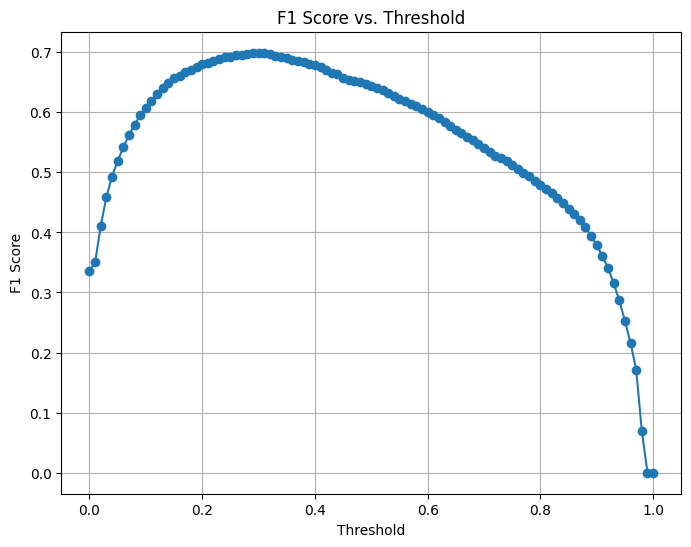

Best Threshold: 0.29
Best F1 Score: 0.699128297048296


In [49]:
thresholds = np.arange(0.0, 1.01, 0.01).tolist()
test_thresholds(trainset['labels'], preds, thresholds)

In [50]:
preds = custom_pipeline(validset['texts'])

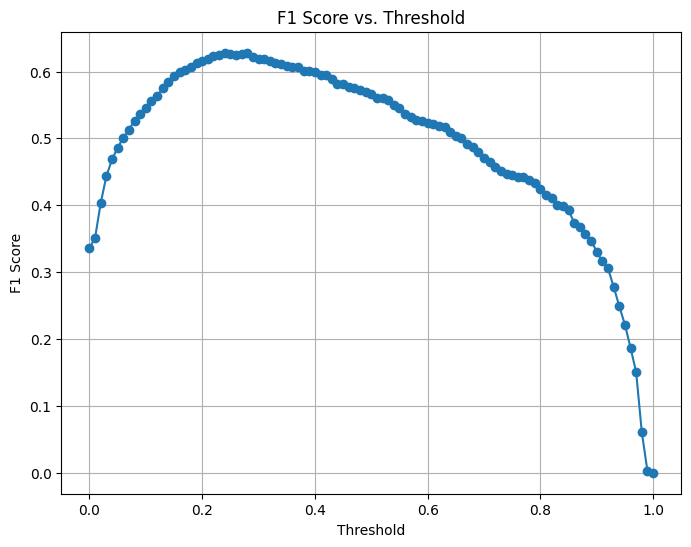

Best Threshold: 0.24
Best F1 Score: 0.6281091095976719


In [51]:
thresholds = np.arange(0.0, 1.01, 0.01).tolist()
test_thresholds(validset['labels'], preds, thresholds)

## Check step 1200

In [52]:
best_model_checkpoint_step = 1200
print(f"The best model was saved at step {best_model_checkpoint_step}.")

model_checkpoint = model_folder/'roberta-twitter'/f'checkpoint-{best_model_checkpoint_step}'
model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint
)
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

The best model was saved at step 1200.


In [53]:
checkpoint = str(model_folder/'roberta-twitter'/f'checkpoint-{best_model_checkpoint_step}')
custom_pipeline = pipeline(
    task="text-classification",
    model=checkpoint,
    tokenizer=checkpoint,
    device=torch.cuda.current_device(),
    top_k=None)

In [54]:
preds = custom_pipeline(trainset['texts'])

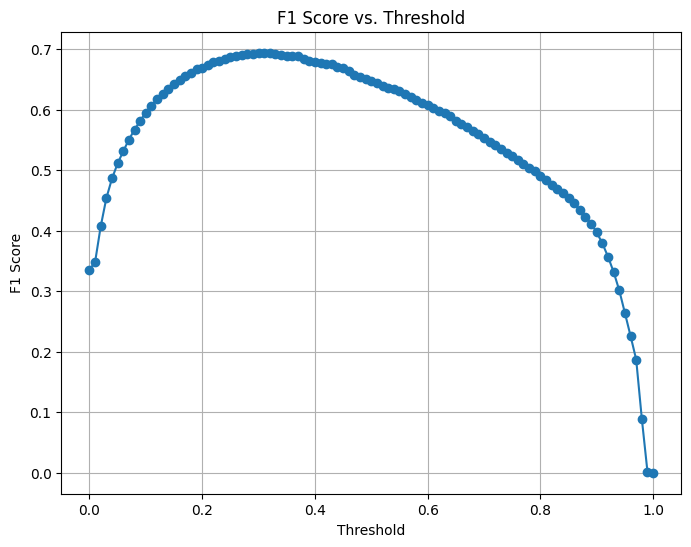

Best Threshold: 0.31
Best F1 Score: 0.6943058879820383


In [55]:
thresholds = np.arange(0.0, 1.01, 0.01).tolist()
test_thresholds(trainset['labels'], preds, thresholds)

In [56]:
preds = custom_pipeline(validset['texts'])

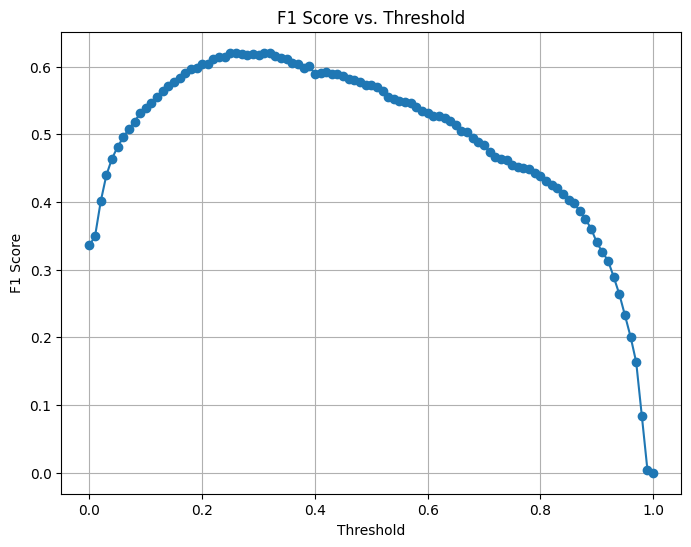

Best Threshold: 0.26
Best F1 Score: 0.6205536611269713


In [57]:
thresholds = np.arange(0.0, 1.01, 0.01).tolist()
test_thresholds(validset['labels'], preds, thresholds)

# Submission to Kaggle

In [48]:
X_test = test['Tweet']

In [49]:
X_test_cleaned = X_test.apply(demoji_text).apply(convert_emoji).apply(strip_all_entities).apply(clean_hashtags).apply(filter_chars).apply(remove_mult_spaces).values

In [50]:
testset = Dataset.from_dict({
    'texts': X_test_cleaned,
})

In [51]:
preds = custom_pipeline(testset['texts'])

In [52]:
pred_df = pd.DataFrame(columns=test.columns[2:])

for pred in preds:
    temp_ans = label2id
    for pred_label in pred:
        if pred_label['score']>0.26:
            temp_ans[pred_label['label']] = 1
        else: 
            temp_ans[pred_label['label']] = 0
    pred_df = pd.concat([pred_df, pd.DataFrame([temp_ans])], ignore_index=True)

In [53]:
sub_df = pd.concat([test[['ID']], pred_df], axis=1)
sub_df.to_csv(model_folder/'first_sub.csv', index = False)

In [54]:
comp = 'emotion-detection-spring2014'
api.competition_submit(model_folder/'first_sub.csv', 'preprocessing', comp)

100%|██████████| 108k/108k [00:01<00:00, 98.6kB/s] 


Successfully submitted to Emotion Detection Spring2024